In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from experiments.load_model import load_model

In [92]:

import torch
import pickle
import numpy as np
from pathlib import Path
import sys

from learning import StateEncoder, initialize_encoder_random
from problems import GridworldProblem
from policies import GreedyPolicy
from omegaconf import OmegaConf
import copy
from typing import Optional, Callable, List


In [4]:
import torch

In [5]:
from omegaconf import OmegaConf

In [6]:
path = '/home/de7281/thesis/interp-planning/interp-planning/interp-planning-v2'

In [7]:
model = load_model(path + '/model.pt')

Successfully loaded model from: /home/de7281/thesis/interp-planning/interp-planning/interp-planning-v2/model.pt
Configuration:
  Environment: K=50, N=5, O=0
  Model: latent_dim=16, hidden_dims=[128, 128, 64]
  Waypoint type: c
  Seed: 42


In [8]:
with open(path + '/results.pkl', 'rb') as file:
    # Load the object from the pickle file
    results = pickle.load(file)

In [9]:
with open(path + '/training_history.pkl', 'rb') as file:
    # Load the object from the pickle file
    history = pickle.load(file)

In [10]:
model.keys()

dict_keys(['psi_net', 'A_np', 'log_lambda_np', 'config'])

In [11]:
model['psi_net']

StateEncoder(
  (network): Sequential(
    (0): Linear(in_features=5, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=16, bias=True)
  )
)

In [197]:
def naive_s_encoder(state):
    return state - np.array([25, 25, 25, 25, 25])

def naive_g_encoder(state):
    return state - np.array([25, 25, 25, 25, 25])

naive_A = np.eye(model['config']['env']['N'])

In [17]:
def s_encoder(state):
    """Encode state: A @ psi(state)"""
    with torch.no_grad():
        state_tensor = torch.from_numpy(state.astype(np.float32)).unsqueeze(0)
        emb = model['psi_net'](state_tensor).squeeze(0).numpy()
        return model['A_np'] @ emb
    
def g_encoder(state):
    with torch.no_grad():
        state_tensor = torch.from_numpy(state.astype(np.float32)).unsqueeze(0)
        emb = model['psi_net'](state_tensor).squeeze(0).numpy()
        return emb
    

In [18]:
s_encoder(np.array([0, 0, 0, 0, 0]))

array([-3.3077586 ,  0.87607634,  0.7749481 ,  1.9039533 ,  2.9599307 ,
       -2.3434603 ,  1.6780741 , -3.0845146 , -0.91979414,  1.8853636 ,
        1.5275254 , -0.1537779 ,  0.31150183,  3.9716268 , -2.509223  ,
       -1.6232913 ], dtype=float32)

In [19]:
encodings = []
for i in range(1000):
    rand_pt = np.random.randint(0, 50, 5)
    encoding = s_encoder(rand_pt)
    encodings.append((rand_pt, encoding))

In [20]:
import matplotlib.pyplot as plt

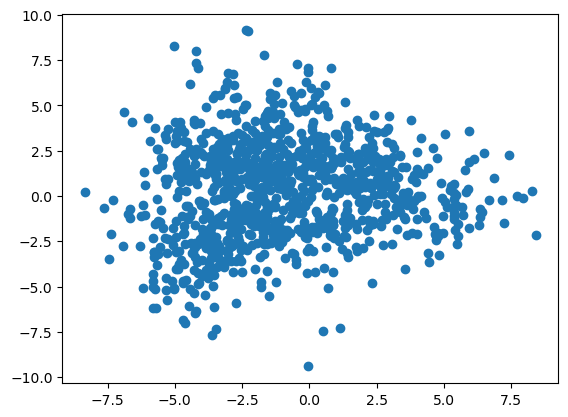

In [21]:
plt.scatter([x[1][4] for x in encodings], [x[1][1] for x in encodings])

In [127]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from typing import Tuple

def g_waypoint(
    start: np.ndarray,
    goal: np.ndarray,
    psi: Callable[[np.ndarray], np.ndarray],
    A: np.ndarray,
    buffer: List[np.ndarray],
    M: int,
    K: int,              # number of mixture components (default = M)
    T: float = 1.0,
    n_iters: int = 10,
    covariance_type: str = "full"
) -> np.ndarray:
    """
    Compute a GMM-based C-Waypoint (continuous approximation).

    Steps:
    1. Compute importance weights p_i over M sampled buffer states.
    2. Fit a Gaussian Mixture Model over their psi-embeddings using p_i.
    3. Sample once from the GMM to get a continuous waypoint.

    Args:
        start: start state
        goal: goal state
        psi: encoder function psi(s) -> embedding
        A: learned linear operator
        buffer: replay buffer of states
        M: number of states to sample from buffer
        T: temperature for softmax weighting
        K: number of mixture components (defaults to M)
        covariance_type: GMM covariance type ("full", "diag", etc.)

    Returns:
        waypoint_emb: a sampled waypoint in latent space
    """

    # Encode start and goal
    start_emb = A @ psi(start)
    goal_emb = psi(goal)

    # Sample states from buffer
    num_samples = min(M, len(buffer))
    idx = np.random.choice(len(buffer), size=num_samples, replace=False)
    sampled_states = [buffer[i] for i in idx]

    # Compute psi embeddings
    psi_embs = np.array([psi(s) for s in sampled_states])  # shape (M, d)

    # Compute the C-Planning cost for each sampled state
    # cost(s) = ||psi(s) - A psi(start)||^2 + ||A psi(s) - psi(goal)||^2
    costs = np.sum((psi_embs - start_emb) ** 2, axis=1) \
          + np.sum((psi_embs @ A.T - goal_emb) ** 2, axis=1)

    # Softmax probabilities over negative cost
    logits = -costs / (2*T)
    logits -= np.max(logits)
    p = np.exp(logits)
    p /= np.sum(p)

    params = fit_gmm_match_probs(psi_embs, p, K, 
                                 n_iters=n_iters)
    

    # Sample 1 waypoint from the GMM
    waypoint_emb = sample_from_fitted_gmm(params)

    return waypoint_emb

def fit_gmm_match_probs(
    psi_embs: np.ndarray,       # shape (M, d)
    p: np.ndarray,              # shape (M,), sums to 1
    K: int = 5,
    n_iters: int = 10,
    lr: float = 1e-2,
    min_diag: float = 1e-6,
    device: str = "cpu",
) -> dict:
    """
    Fit a K-component GMM so that the discrete probabilities defined by normalizing
    g(psi_i) over the M points match target p as closely as possible (minimize KL).
    Returns dict with learned params (weights, means, cov_cholesky).
    """

    psi = torch.tensor(psi_embs, dtype=torch.float32, device=device)  # (M, d)
    p_tensor = torch.tensor(p.astype(np.float32), dtype=torch.float32, device=device)  # (M,)
    M, d = psi.shape

    # Parameters:
    # - raw_weights: (K,) -> softmax -> mixture weights
    # - means: (K, d)
    # - lower-tri cholesky factors: (K, d, d) represented as unconstrained bilinear params for lower triangle
    raw_weights = nn.Parameter(torch.zeros(K, device=device))
    means = nn.Parameter(torch.randn(K, d, device=device) * (psi.std().item() + 1e-2) + psi.mean(0))
    # We'll represent cholesky factors as lower-tri params stored in a matrix
    L_params = nn.Parameter(torch.stack([torch.eye(d, device=device) for _ in range(K)]) * 0.1)

    optimizer = optim.Adam([raw_weights, means, L_params], lr=lr)

    # Helper to compute multivariate normal density at all psi points
    def gmm_pdf_at_points():
        # compute mixture weights
        weights = torch.softmax(raw_weights, dim=0)  # (K,)

        # For numerical stability, compute logpdfs
        # For each component k compute log N(psi | mean_k, Sigma_k)
        logpdfs = []
        for k in range(K):
            L = torch.tril(L_params[k])  # (d,d) lower triangular
            # ensure positive diagonal
            diag = torch.diag(L)
            # push diag to be > min_diag
            diag = torch.clamp(diag, min=min_diag)
            L = L - torch.diag(torch.diag(L)) + torch.diag(diag)

            # compute Sigma = L L^T
            # logdet Sigma = 2 * sum log diag(L)
            logdet = 2.0 * torch.sum(torch.log(diag + 1e-12))

            diff = psi - means[k]  # (M, d)
            # Solve y = L^{-1} diff^T  -> use triangular solve
            # triangular_solve expects (d, M) RHS
            y, _ = torch.triangular_solve(diff.t(), L, upper=False)
            mahal = torch.sum(y * y, dim=0)  # (M,)
            log_const = -0.5 * (d * np.log(2 * np.pi) + logdet)
            logpdf_k = log_const - 0.5 * mahal  # (M,)
            logpdfs.append(logpdf_k.unsqueeze(0))
        logpdfs = torch.cat(logpdfs, dim=0)  # (K, M)

        # log g(psi_i) = logsumexp_k [ log weight_k + logpdf_k(i) ]
        log_weights = torch.log(weights + 1e-12).unsqueeze(1)  # (K,1)
        log_component = log_weights + logpdfs  # (K,M)
        log_g = torch.logsumexp(log_component, dim=0)  # (M,)
        g = torch.exp(log_g)  # (M,)
        return g, log_g, weights

    # Optimization loop
    for it in range(n_iters):
        print(it)
        optimizer.zero_grad()
        g, log_g, weights = gmm_pdf_at_points()  # g: (M,)
        # normalize to discrete q
        q = g / (g.sum() + 1e-12)  # (M,)

        # loss = KL(p || q) = - sum_i p_i * log q_i  + const (we drop const)
        loss = -torch.sum(p_tensor * torch.log(q + 1e-12))
        loss.backward()
        optimizer.step()

        # (optional) small step to prevent collapse of L diagonals: nudge diagonals up
        with torch.no_grad():
            for k in range(K):
                L = torch.tril(L_params[k])
                diag = torch.diag(L)
                diag_clamped = torch.clamp(diag, min=min_diag)
                newL = L - torch.diag(diag) + torch.diag(diag_clamped)
                L_params[k].copy_(newL)

        # simple early stopping if loss small, optionally print
        if it % 200 == 0:
            loss_val = loss.item()
            # print(f"iter {it}, loss {loss_val:.6f}")

    # Return parameters as numpy
    weights_np = torch.softmax(raw_weights, dim=0).detach().cpu().numpy()
    means_np = means.detach().cpu().numpy()
    L_np = torch.tril(L_params.detach()).cpu().numpy()  # (K, d, d)

    return {
        "weights": weights_np,
        "means": means_np,
        "cholesky": L_np,
        "loss": loss.item()
    }


def sample_from_fitted_gmm(params: dict, n: int = 1) -> np.ndarray:
    """
    Sample n points from the fitted GMM returned by fit_gmm_match_probs.
    """
    weights = params["weights"]
    means = params["means"]
    Ls = params["cholesky"]
    K, d = means.shape

    comps = np.random.choice(K, size=n, p=weights)
    samples = np.zeros((n, d))
    for idx, k in enumerate(comps):
        z = np.random.randn(d)
        L = Ls[k]
        samples[idx] = means[k] + L @ z
    return samples if n > 1 else samples[0]


In [128]:
from waypoints import c_waypoint, i_waypoint

In [198]:
start = np.array([0, 0, 0, 0, 0])
goal = np.array([30, 30, 30, 30, 30])


In [199]:
buffer = []
for i in range(10000):
    buffer.append(np.random.randint(0, 50, 5))

In [200]:
def closest_real_point(waypoint, buffer, s_encoder):
    dists = np.zeros(len(buffer))
    for i in range(len(buffer)):
        dists[i] = np.linalg.norm(s_encoder(buffer[i]) - waypoint)
    return buffer[np.argmin(dists)]


In [209]:
waypoint = c_waypoint(start, goal, naive_g_encoder, naive_A, buffer, M=50)

In [210]:
closest_real_point(waypoint, buffer, naive_s_encoder)

array([11, 19,  8, 23, 20])

In [219]:
waypoint = i_waypoint(start, goal, naive_g_encoder, naive_A, c=10)

[-9.95475113 -9.95475113 -9.95475113 -9.95475113 -9.95475113] [[0.49773756 0.         0.         0.         0.        ]
 [0.         0.49773756 0.         0.         0.        ]
 [0.         0.         0.49773756 0.         0.        ]
 [0.         0.         0.         0.49773756 0.        ]
 [0.         0.         0.         0.         0.49773756]]


In [220]:
closest_real_point(waypoint, buffer, naive_s_encoder)

array([18, 16, 16, 18, 12])

In [233]:
waypoint = g_waypoint(start, goal, naive_s_encoder, naive_A, buffer, M=50, K=3, n_iters=10)

0
1
2
3
4
5
6
7
8
9


In [234]:
closest_real_point(waypoint, buffer, naive_s_encoder)

array([18, 10, 39, 26, 23])

In [68]:
psi_embs = np.array([naive_g_encoder(x) for x in buffer[:100]])
p = np.array([1/100 for i in range(100)])

In [71]:
params = fit_gmm_match_probs(psi_embs, p, n_iters=10)

0
1
2
3
4
5
6
7
8
9


In [87]:
waypoint = sample_from_fitted_gmm(params)

In [88]:
closest_real_point(waypoint, buffer, naive_s_encoder)

array([38, 29, 16, 45, 30])